# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [2]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non

### On reprend les éléments du notebook de l'étape 2

In [3]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape2_clean.csv")

# Partie 4 - Améliorez l'approche de classification

### Recommandation 1 - Avant toute implémentation en code, mettre sur le papier votre approche de modélisation. C’est-à-dire : avec quelle méthodologie je découpe mon jeu de données en apprentissage et test, de quelles métriques d’évaluation je vais avoir besoin etc.

* L'objectif va être de gérer le déséquilibre de notre jeu de données. Nous devons également mieux le stratifier et déterminer le bon seuil de classification avec une courbe PR. Nous sommes dans une situation de déséquilibre alors la courbe ROC n'est pas adaptée.

* D'après les résultats obtenus par l'étape 3, il semble important de mettre l'accent sur l'amélioration de la métrique Recall qui n'est pas bonne pour chacun des modèles testés.
* D'autant plus dans un sens métier, il est plus judicieux de bien trouver les Faux Négatifs, c'est à dire les salariés qui ont démissionné mais qui sont considérés comme encore dans l'entreprise.
* La métrique Recall et la matrice de confusion vont nous permettre de mieux comprendre les résultats.
* Ajout de la balanced_accuracy_score afin de pouvoir comparer les modèles
* Utilisation également de la moyenne et de l'écart-type pour juger de la performance.
* La métrique Accuracy n'est pas utilisable pour le moment car le déséquilibre fausse la métrique, elle va trouver facilement le Non qui domine notre jeu de données à hauteur de 84%.
* Utilisation d'un calcul avec Fbeta pour déterminer le bons seuil à appliquer

Réalisation de différents tests sur 3 modèles non linéaires (il est demandé dans l'énoncé d'utiliser un modèle non linéaire):
* Choix du modèle non-linéaire RandomForest
* Choix du modèle non-linéaire XGBoost
* Choix du modèle non-linéaire CatBoost

## Création d'une fonction pour appliquer nos modèles

### Application des recommandations suivantes :
* Capitaliser sur les fonctions existantes dans sklearn et privilégier leur utilisation (notamment pour la stratification), à moins que votre méthodologie soit très personnalisée.

* Pendant votre validation croisée, stocker les métriques de chaque itération de Fold dans une liste. Il est très utile de calculer une moyenne ainsi qu’un écart-type sur ces listes. Cela vous donnera une bonne indication sur l’existence ou non d’un overfit, ainsi que la capacité d’un modèle à généraliser son apprentissage à de nouvelles données.

* Utiliser la courbe précision rappel pour déterminer le seuil optimal que doit utiliser votre modèle pour classifier vos observations.

* Si vous êtes déjà à l’aise au niveau du code pour utiliser les différents concepts et librairies, vous pouvez vous intéresser aux fonctionnalités pipelines de sklearn pour mieux organiser vos modélisations.

#### Nous reprenons notre X/y et nos colonnes encodées ou non

In [4]:
X, y = prepare_xy(donnees_modelisation)
features_a_scaler, features_encodees = scaler_ou_non()

### Base pour génération de modèle

In [5]:
# Création d'une fonction et pour figer nos conditions
def modelisation(model, donnees_modelisation, target_col='a_quitte_l_entreprise', test_size=0.2, random_state=42):
# Séparation de X et y
    X, y

# Test en jeu d'apprentissage et de test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size, random_state=random_state)
    
 # Demande d'une transformation des colonnes non encodées en scaling et création d'un pipeline
    preprocessor = ColumnTransformer(
        transformers = [
            ('num',StandardScaler(),features_a_scaler),
            ('cat','passthrough',features_encodees)
        ])
    pipeline = Pipeline(steps=[
        ('preproccesor', preprocessor),
        ('model', model)
    ])
# Choix des indicateurs de performance et création de la validation croisée    
    scoring = ['precision','recall','f1','average_precision','balanced_accuracy'] # average_precision = PR AUC
    cv_results = cross_validate(
        pipeline,
        X_train, y_train, # validation croisée que sur l'entraînement
        cv=StratifiedKFold(n_splits=3), #KFold va renvoyer des plis stratifiés
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    print("=== Résultats CV (train vs val) ===")

# Boucle pour calcul de nos indicateurs
    for metric in scoring:
        tr = cv_results[f"train_{metric}"]
        te = cv_results[f"test_{metric}"]
        print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

# Entraînement du modèle
    pipeline.fit(X_train,y_train)

# Prédictions sur tain/test et ajout de proba_test
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    proba_test = pipeline.predict_proba(X_test)[:,1] # contenant la probabilité que chaque échantillon soit positif, notre valeur cible.

# Histogramme des probabilités
    plt.hist(proba_test)
    plt.title("Histogramme des probabilité")
    plt.xlabel("Probabilité entre 0 et 1")
    plt.ylabel("Nombre de personnes")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Calcul Average Precision sur Test. C'est la moyenne pondérée des précisions obtenues à chaque seuil
    ap_test = average_precision_score(y_test, proba_test) # proba_test : utilisation des probabilités de Oui ou Non
    print(f"\nPR AUC (Average Precision) — TEST : {ap_test:.3f}")

# Calcul du Fbeta score afin de mettre plus de poids sur le rappel
    precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test) # création de la PR
    beta = 2 # 2 mets l’accent sur le rappel, sans négliger la précision
    f_beta = (1 + beta**2) * (precision_test * recall_test) / (beta**2 * precision_test + recall_test)
    idx = np.nanargmax(f_beta[:-1])   # -1 car le dernier point n'a pas de seuil/on prend le meilleur résultat
    best_thr = thresholds_test[idx] # prendre le meilleur seuil de probabilité 

    print(f"Seuil optimal (F{beta}) : {best_thr:.3f}")
    print(f"Precision={precision_test[idx]:.3f}, Recall={recall_test[idx]:.3f}, F{beta}={f_beta[idx]:.3f}")
   
# Graphique de la courbe Précision Rappel
    plt.plot(recall_test, precision_test, label="Courbe PR")
    plt.scatter(recall_test[idx], precision_test[idx], color="red", zorder=5, label=f"Best F{beta}") # ajout du seuil maximal
    plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (Test Set)")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Application du seuil optimal
    seuil_optimal = best_thr
    y_pred_custom = (proba_test >= seuil_optimal).astype(int)

# Génération de 2 classfication report, l'original vs le seuil optimal
    print("=== balanced accuracy score - TEST ===")
    print(balanced_accuracy_score(y_test, y_pred_test))
    print("=== Classification Report - TEST ===")
    print(classification_report(y_test, y_pred_test, digits=3))
    print("=== Classification Report — TEST avec seuil optimal ===")
    print(classification_report(y_test, y_pred_custom, digits=3))

    classes = sorted(y_test.unique())
    cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=classes)
    print("=== Matrice de confusion - TEST ===")
    print(cm_test)

    cm_test_optimal  = confusion_matrix(y_test,  y_pred_custom,  labels=classes)
    print("=== Matrice de confusion - TEST seuil optimal ===")
    print(cm_test_optimal)

    return model

#### Résultats pour le RandomForest

=== Résultats CV (train vs val) ===
precision         : train 0.733 ± 0.038 vs val 0.516 ± 0.068
recall            : train 0.848 ± 0.012 vs val 0.480 ± 0.047
f1                : train 0.786 ± 0.023 vs val 0.493 ± 0.027
average_precision : train 0.880 ± 0.020 vs val 0.540 ± 0.019
balanced_accuracy : train 0.893 ± 0.008 vs val 0.692 ± 0.016


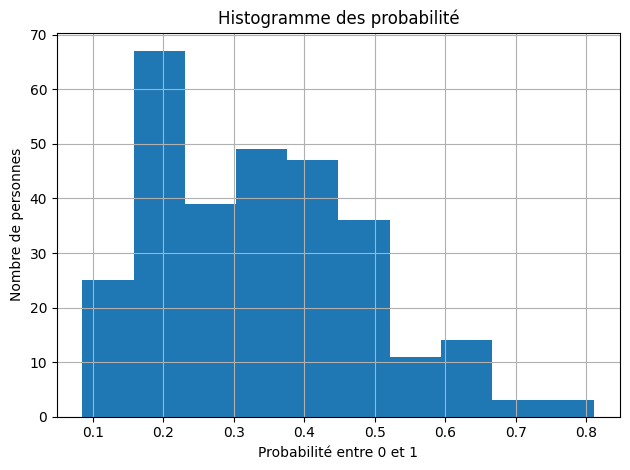


PR AUC (Average Precision) — TEST : 0.346
Seuil optimal (F2) : 0.388
Precision=0.265, Recall=0.692, F2=0.523


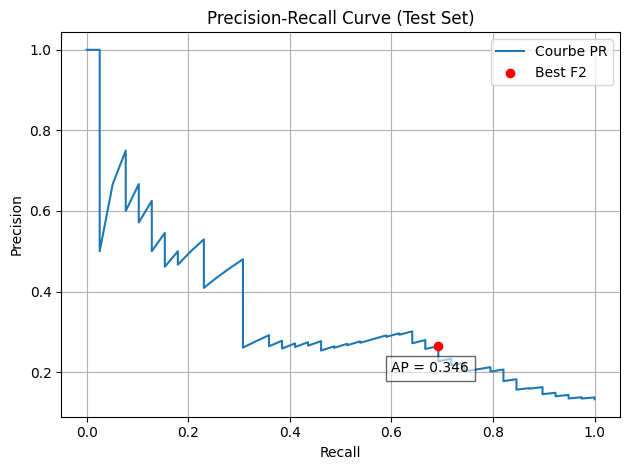

=== balanced accuracy score - TEST ===
0.6009049773755657
=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.894     0.894     0.894       255
           1      0.308     0.308     0.308        39

    accuracy                          0.816       294
   macro avg      0.601     0.601     0.601       294
weighted avg      0.816     0.816     0.816       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.938     0.706     0.805       255
           1      0.265     0.692     0.383        39

    accuracy                          0.704       294
   macro avg      0.601     0.699     0.594       294
weighted avg      0.848     0.704     0.749       294

=== Matrice de confusion - TEST ===
[[228  27]
 [ 27  12]]
=== Matrice de confusion - TEST seuil optimal ===
[[180  75]
 [ 12  27]]


,n_estimators,300
,criterion,'gini'
,max_depth,6
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
modelisation(RandomForestClassifier(
    random_state=42,
    n_estimators=300,
    max_depth=6,
    min_samples_split=10,
    class_weight={0: 0.60, 1: 3.12}),  # poids manuels,
    donnees_modelisation) 

#### Interprétation du RandomForest
* Avec l'ajout d'hyperparamètres, on améliore notre modèle. On passe d'un recall de 0,11 à 0,31.
* Avec le Fbeta, evidemment le poids change et nous avons un bon score de recall de 0,69 mais pour 0,27 de précision

Avec les nouveaux paramètres :
Precision (val = 0.516 ± 0.068)
* Quand le modèle prédit qu’un salarié partira, il a raison environ 51% du temps. La précision est moyenne : il y a encore pas mal de faux positifs.

Recall (val = 0.480 ± 0.047)
* Le modèle arrive à détecter environ 48% des vrais départs.

F1-score (val = 0.493 ± 0.027)
* L’équilibre entre précision et rappel est faible (≈0.49).

Average Precision (val = 0.540 ± 0.019)
* La courbe PR montre que le modèle fait mieux qu’un tirage aléatoire (qui donnerait 0.16 vu le déséquilibre).Mais ça reste assez limité.

Balanced Accuracy (val = 0.692 ± 0.016)
* En tenant compte du déséquilibre, le modèle classe correctement environ 69% des cas. C'est une métrique plus juste que l’accuracy brute et elle confirme une performance correcte mais pas optimale.

### Résultats pour le XGBoost

=== Résultats CV (train vs val) ===
precision         : train 0.993 ± 0.006 vs val 0.576 ± 0.045
recall            : train 1.000 ± 0.000 vs val 0.490 ± 0.070
f1                : train 0.996 ± 0.003 vs val 0.524 ± 0.030
average_precision : train 1.000 ± 0.000 vs val 0.544 ± 0.015
balanced_accuracy : train 0.999 ± 0.001 vs val 0.707 ± 0.025


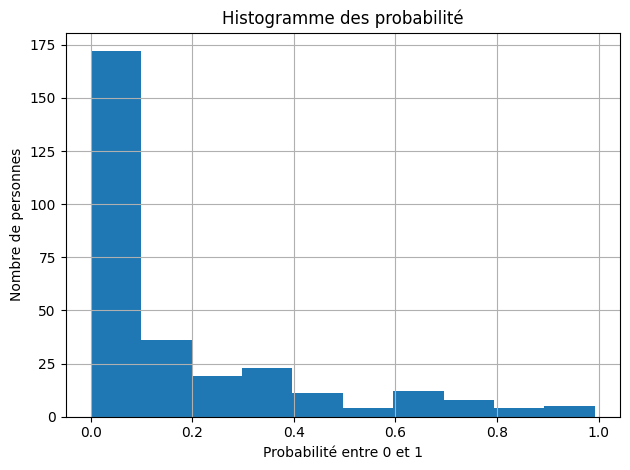


PR AUC (Average Precision) — TEST : 0.348
Seuil optimal (F2) : 0.163
Precision=0.295, Recall=0.718, F2=0.558


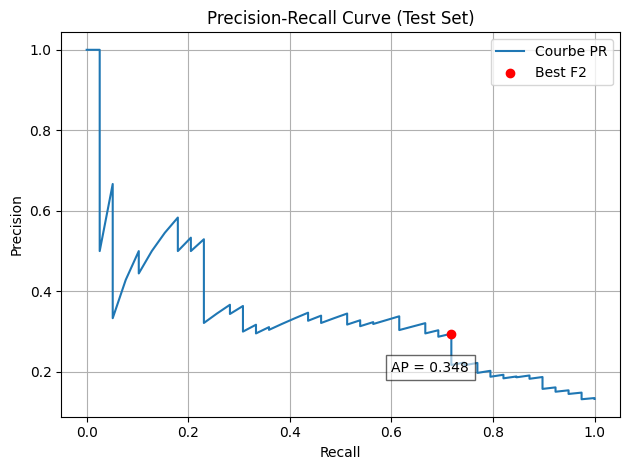

=== balanced accuracy score - TEST ===
0.6126696832579186
=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.897     0.918     0.907       255
           1      0.364     0.308     0.333        39

    accuracy                          0.837       294
   macro avg      0.630     0.613     0.620       294
weighted avg      0.826     0.837     0.831       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.945     0.737     0.828       255
           1      0.295     0.718     0.418        39

    accuracy                          0.735       294
   macro avg      0.620     0.728     0.623       294
weighted avg      0.859     0.735     0.774       294

=== Matrice de confusion - TEST ===
[[234  21]
 [ 27  12]]
=== Matrice de confusion - TEST seuil optimal ===
[[188  67]
 [ 11  28]]


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
modelisation(XGBClassifier(n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=5.25,  # ratio négatifs / positifs
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"), donnees_modelisation)

#### On note encore de l'overfit, on arrive moins à trouver les bons hyperparamètres. On va privilégier les modèles où on peut gérer le class weight

### Modèle CatBoostClassifier

=== Résultats CV (train vs val) ===
precision         : train 0.714 ± 0.027 vs val 0.498 ± 0.039
recall            : train 0.942 ± 0.007 vs val 0.586 ± 0.084
f1                : train 0.812 ± 0.020 vs val 0.532 ± 0.021
average_precision : train 0.924 ± 0.013 vs val 0.580 ± 0.023
balanced_accuracy : train 0.933 ± 0.008 vs val 0.731 ± 0.026


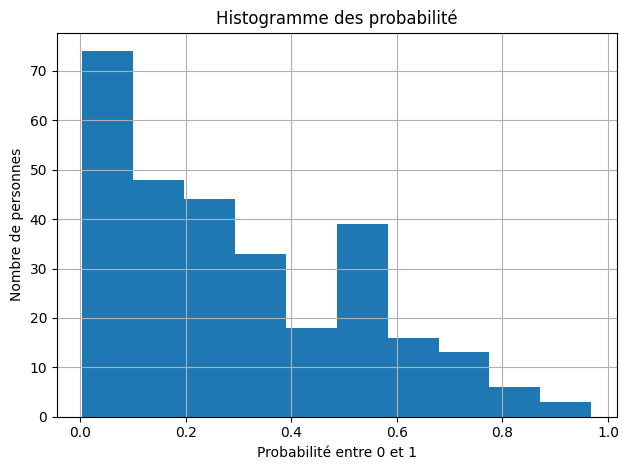


PR AUC (Average Precision) — TEST : 0.347
Seuil optimal (F2) : 0.361
Precision=0.260, Recall=0.692, F2=0.519


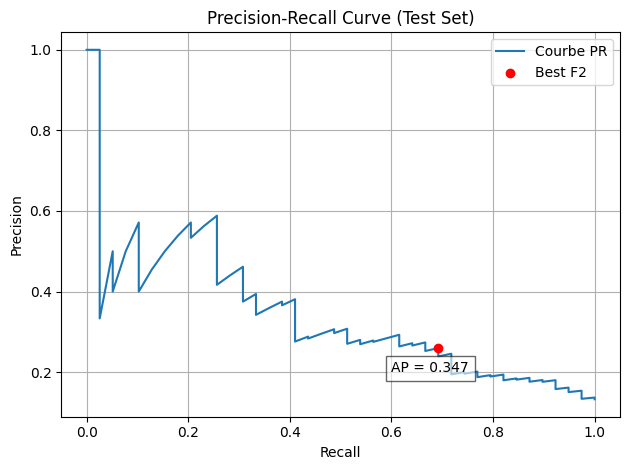

=== balanced accuracy score - TEST ===
0.6564102564102564
=== Classification Report - TEST ===
              precision    recall  f1-score   support

           0      0.915     0.800     0.854       255
           1      0.282     0.513     0.364        39

    accuracy                          0.762       294
   macro avg      0.598     0.656     0.609       294
weighted avg      0.831     0.762     0.789       294

=== Classification Report — TEST avec seuil optimal ===
              precision    recall  f1-score   support

           0      0.937     0.698     0.800       255
           1      0.260     0.692     0.378        39

    accuracy                          0.697       294
   macro avg      0.598     0.695     0.589       294
weighted avg      0.847     0.697     0.744       294

=== Matrice de confusion - TEST ===
[[204  51]
 [ 19  20]]
=== Matrice de confusion - TEST seuil optimal ===
[[178  77]
 [ 12  27]]


In [9]:
modelisation(CatBoostClassifier(iterations=300,
    depth=3,                # profondeur modérée
    learning_rate=0.05,
    class_weights=[1, 5],   # idem XGBoost → ratio négatifs/positifs
    random_state=42,
    verbose=0), donnees_modelisation)

#### Interprétation CatBoost
Précision (val = 0.498) : le modèle fait pas mal de faux positifs, il a du mal à être sélectif.
* Recall (val = 0.586) : il récupère quand même 59 % des vrais positifs, mieux que le RandomForest précédent (0.31).

* F1 (val = 0.532) : équilibre moyen entre précision et rappel, mais cohérent vu le dataset déséquilibré.
* Average Precision (val = 0.580) : la courbe PR est correcte, ce qui montre que le modèle n’est pas aléatoire mais reste perfectible.
* Balanced Accuracy (val = 0.731) : il gère mieux l’équilibre classes majoritaires/minoritaires que le RandomForest (0.65).

CatBoost généralise mieux que RandomForest : l’écart train/val est plus raisonnable (moins d’overfit).
* Le recall est nettement meilleur : identification de plus de salariés qui quittent l’entreprise.
* Le modèle est plus stable : l’écart-type (±) est faible, donc les résultats sont consistants d’un fold à l’autre.